In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station



In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
inspector = sqlalchemy.inspect(engine)

In [10]:



columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
for row in session.query(measurement.id, measurement.station, measurement.date, \
                        measurement.prcp, measurement.tobs).limit(1).all():
    print(row)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)


In [14]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
for row in session.query(station.id, station.station, station.name, \
                        station.latitude, station.longitude, station.elevation).limit(1).all():
    print(row)

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)


# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date, measurement.id).order_by(measurement.date.desc()).first()
recent_date

('2017-08-23', 2724)

In [17]:
# question_about_date_id = session.query(measurement.date, measurement.id, measurement.station, measurement.prcp, measurement.tobs).\
#     filter(measurement.date > '2016-08-22').\
#     order_by(measurement.date)
# for row in question_about_date_id:
#     print(row)

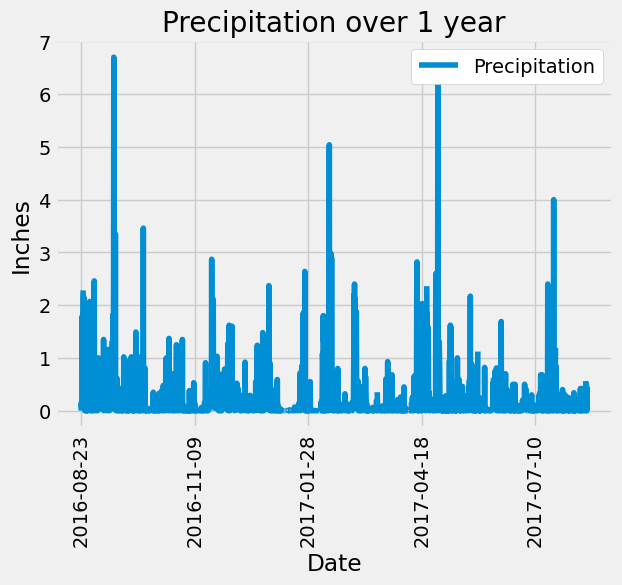

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >=  (dt.date(2017,8,23)- dt.timedelta(days=365))).\
    order_by(measurement.date).all()    

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data, columns =['date','precipitation'])

# Sort the dataframe by date
df.set_index('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot('date','precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')

plt.xticks( rotation='vertical')
plt.title("Precipitation over 1 year")
plt.legend(['Precipitation'], loc="upper right",facecolor='white', framealpha=1)

plt.show()



In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data


# Exploratory Station Analysis

In [29]:
# Design a query to calculate the total number stations in the dataset
st_query = session.query(station.station)
for station in st_query:
    print(station)

ArgumentError: Textual column expression 'USC00516128' should be explicitly declared with text('USC00516128'), or use column('USC00516128') for more specificity

In [28]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()